In [1]:
pip install pyspark

     |████████████████████████████████| 281.3 MB 42 kB/s 
     |████████████████████████████████| 198 kB 55.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=b6455bbf9c6d4ec4e46b5102afd24cf8a33edf4ab18d6e18cee4ed0d1adcc3cc
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import col

sc = SparkContext.getOrCreate()
sqlCtx = SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler 
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder

In [3]:
flights_df = pd.read_csv("/content/flights.csv")

In [4]:
flights_df.isnull().sum()

YEAR                       0
MONTH                      0
DAY                        0
DAY_OF_WEEK                0
AIRLINE                    0
FLIGHT_NUMBER              0
TAIL_NUMBER               25
ORIGIN_AIRPORT             0
DESTINATION_AIRPORT        0
SCHEDULED_DEPARTURE        0
DEPARTURE_TIME           568
DEPARTURE_DELAY          568
TAXI_OUT                 573
WHEELS_OFF               573
SCHEDULED_TIME             0
ELAPSED_TIME             606
AIR_TIME                 606
DISTANCE                   0
WHEELS_ON                583
TAXI_IN                  583
SCHEDULED_ARRIVAL          0
ARRIVAL_TIME             583
ARRIVAL_DELAY            607
DIVERTED                   1
CANCELLED                  1
CANCELLATION_REASON    20315
AIR_SYSTEM_DELAY       16622
SECURITY_DELAY         16622
AIRLINE_DELAY          16622
LATE_AIRCRAFT_DELAY    16622
WEATHER_DELAY          16622
dtype: int64

In [5]:
flights_agg = flights_df[['MONTH','DAY','DAY_OF_WEEK','AIRLINE','ORIGIN_AIRPORT',
                          'SCHEDULED_DEPARTURE','SCHEDULED_TIME',
                          'DISTANCE','SCHEDULED_ARRIVAL','DEPARTURE_DELAY']].copy()
flights_agg = flights_agg.dropna(axis=0, how = "any")

In [6]:
flights_agg.isnull().sum()

MONTH                  0
DAY                    0
DAY_OF_WEEK            0
AIRLINE                0
ORIGIN_AIRPORT         0
SCHEDULED_DEPARTURE    0
SCHEDULED_TIME         0
DISTANCE               0
SCHEDULED_ARRIVAL      0
DEPARTURE_DELAY        0
dtype: int64

In [7]:
flights_agg['DELAY'] = np.where(flights_agg['DEPARTURE_DELAY'] <= 0, 0, 1)

In [8]:
no_delay = (flights_agg['DELAY'] == 0).sum()
nobs = len(flights_agg['DELAY'])
no_delay_perc = float(no_delay)/nobs
delay_perc = 1 - no_delay_perc
print(no_delay_perc, delay_perc)

0.5859863209171874 0.4140136790828126


In [9]:
delay = nobs - no_delay
no_delay_indices = flights_agg[flights_agg.DELAY == 0].index
#undersamples no delays to equal same number of delays
np.random.seed(5)
random_indices = np.random.choice(no_delay_indices, delay, replace=False) 
no_delay_sample = flights_agg.loc[random_indices]

In [10]:
no_delay_sample[:10]

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,DEPARTURE_DELAY,DELAY
9012,1,1,4,DL,MCO,1600,159,957,1839,-1.0,0
6219,1,1,4,B6,STT,1305,43,68,1348,-13.0,0
1341,1,1,4,B6,TPA,735,124,814,939,-16.0,0
6080,1,1,4,UA,IAH,1259,150,862,1429,0.0,0
1938,1,1,4,EV,FSD,820,109,483,909,-7.0,0
726,1,1,4,DL,SNA,645,256,1919,1401,-4.0,0
1035,1,1,4,UA,LAS,710,179,1222,1209,-3.0,0
18505,1,2,5,DL,STL,945,94,484,1219,-4.0,0
1197,1,1,4,WN,PIT,725,170,966,1015,0.0,0
13113,1,1,4,OO,SEA,2055,63,224,2158,-8.0,0


In [11]:
delay_sample = flights_agg[flights_agg.DELAY == 1] 
flights_agg_balanced = delay_sample.append(no_delay_sample)

In [12]:
n = int(len(flights_agg_balanced)*0.10)
flights_new_bal = flights_agg_balanced.sample(n, random_state = 314)

In [13]:
no_delay_bal = (flights_new_bal['DELAY'] == 0).sum()
no_delay_perc_bal = float(no_delay_bal)/n
delay_perc_bal = 1 - no_delay_perc_bal
print(no_delay_perc_bal, delay_perc_bal)

0.5112960760998811 0.48870392390011885


In [93]:
flights = pd.read_csv("/content/flights.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Text(0.5, 1.0, 'Flights Over Time')

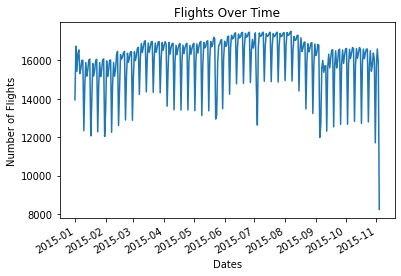

In [97]:
# Flights over time
flights = flights.assign(DATE=pd.to_datetime(flights[['YEAR','MONTH','DAY']]))

flights['DATE'].value_counts().plot()
plt.xlabel('Dates')
plt.ylabel("Number of Flights")
plt.title("Flights Over Time")

Text(0.5, 1.0, 'Delays Over Time')

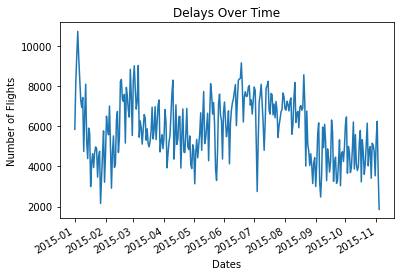

In [98]:
# Delays over time
flightsD = flightsDelays.assign(DATE=pd.to_datetime(flightsDelays[['YEAR','MONTH','DAY']]))

flightsD['DATE'].value_counts().plot()
plt.xlabel('Dates')
plt.ylabel("Number of Flights")
plt.title("Delays Over Time")

In [18]:
flight_df = sqlCtx.createDataFrame(flights_new_bal)
flight_df.show(5)

+-----+---+-----------+-------+--------------+-------------------+--------------+--------+-----------------+---------------+-----+
|MONTH|DAY|DAY_OF_WEEK|AIRLINE|ORIGIN_AIRPORT|SCHEDULED_DEPARTURE|SCHEDULED_TIME|DISTANCE|SCHEDULED_ARRIVAL|DEPARTURE_DELAY|DELAY|
+-----+---+-----------+-------+--------------+-------------------+--------------+--------+-----------------+---------------+-----+
|    1|  2|          5|     DL|           DTW|                835|           310|    1927|             1045|            0.0|    0|
|    1|  1|          4|     DL|           BOS|               1000|           205|    1124|             1225|            4.0|    1|
|    1|  1|          4|     DL|           LGA|               1000|           176|     762|             1256|            0.0|    0|
|    1|  1|          4|     UA|           IAH|                920|           513|    3904|             1353|           42.0|    1|
|    1|  1|          4|     UA|           LAS|               1303|           182|  

In [20]:
flight_df.write.parquet("flight_df.parquet")

In [22]:
flight_df = sqlCtx.read.parquet("/content/flight_df.parquet")

In [23]:
flight_df.show(4)

+-----+---+-----------+-------+--------------+-------------------+--------------+--------+-----------------+---------------+-----+
|MONTH|DAY|DAY_OF_WEEK|AIRLINE|ORIGIN_AIRPORT|SCHEDULED_DEPARTURE|SCHEDULED_TIME|DISTANCE|SCHEDULED_ARRIVAL|DEPARTURE_DELAY|DELAY|
+-----+---+-----------+-------+--------------+-------------------+--------------+--------+-----------------+---------------+-----+
|    1|  2|          5|     DL|           DTW|                835|           310|    1927|             1045|            0.0|    0|
|    1|  1|          4|     DL|           BOS|               1000|           205|    1124|             1225|            4.0|    1|
|    1|  1|          4|     DL|           LGA|               1000|           176|     762|             1256|            0.0|    0|
|    1|  1|          4|     UA|           IAH|                920|           513|    3904|             1353|           42.0|    1|
+-----+---+-----------+-------+--------------+-------------------+--------------+--

In [27]:
# Use OneHotEncoder to map categorical variables to binary vectors
cat_columns = ['MONTH','DAY','DAY_OF_WEEK']
encoders = [OneHotEncoder(inputCol=column, outputCol=column+"_vec") for column in cat_columns]
pipelineOHE = Pipeline(stages=encoders)
flight_df2 = pipelineOHE.fit(flight_df).transform(flight_df)

In [28]:
flight_df2.show(2)

+-----+---+-----------+-------+--------------+-------------------+--------------+--------+-----------------+---------------+-----+---------+-------------+---------------+
|MONTH|DAY|DAY_OF_WEEK|AIRLINE|ORIGIN_AIRPORT|SCHEDULED_DEPARTURE|SCHEDULED_TIME|DISTANCE|SCHEDULED_ARRIVAL|DEPARTURE_DELAY|DELAY|MONTH_vec|      DAY_vec|DAY_OF_WEEK_vec|
+-----+---+-----------+-------+--------------+-------------------+--------------+--------+-----------------+---------------+-----+---------+-------------+---------------+
|    1|  2|          5|     DL|           DTW|                835|           310|    1927|             1045|            0.0|    0|(1,[],[])|    (2,[],[])|      (5,[],[])|
|    1|  1|          4|     DL|           BOS|               1000|           205|    1124|             1225|            4.0|    1|(1,[],[])|(2,[1],[1.0])|  (5,[4],[1.0])|
+-----+---+-----------+-------+--------------+-------------------+--------------+--------+-----------------+---------------+-----+---------+-----

In [29]:
assembler = VectorAssembler(inputCols=['MONTH_vec', 'DAY_vec', 'DAY_OF_WEEK_vec',
                                       'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'DISTANCE', 
                                       'SCHEDULED_ARRIVAL'], outputCol="features")

In [30]:
# Apply vector assembler to data
transformed = assembler.transform(flight_df2)

In [31]:
transformed.select(['DELAY', 'features']).show(5)

+-----+--------------------+
|DELAY|            features|
+-----+--------------------+
|    0|(12,[8,9,10,11],[...|
|    1|(12,[2,7,8,9,10,1...|
|    0|(12,[2,7,8,9,10,1...|
|    1|(12,[2,7,8,9,10,1...|
|    1|(12,[2,7,8,9,10,1...|
+-----+--------------------+
only showing top 5 rows



In [32]:
# Convert to RDD
dataRDD = transformed.select(['DELAY','features']).rdd.map(tuple)

In [33]:
# Map label to binary values, then convert to LabeledPoint
lp = dataRDD.map(lambda row : (0 if row[0] == 0 else 1, Vectors.dense(row[1])))    \
            .map(lambda row : LabeledPoint(row[0], row[1]))

In [34]:
lp.take(5)

[LabeledPoint(0.0, [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,835.0,310.0,1927.0,1045.0]),
 LabeledPoint(1.0, [0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1000.0,205.0,1124.0,1225.0]),
 LabeledPoint(0.0, [0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1000.0,176.0,762.0,1256.0]),
 LabeledPoint(1.0, [0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,920.0,513.0,3904.0,1353.0]),
 LabeledPoint(1.0, [0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1303.0,182.0,1222.0,1805.0])]

In [35]:
split = lp.randomSplit([0.8, 0.2], 314)
training = split[0]
test = split[1]

LOGISTIC REGRESSION

In [36]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel

In [37]:
# Build model
LR_model = LogisticRegressionWithLBFGS.train(training)

In [38]:
# Evaluate model on training data
LR_LAPtrain = training.map(lambda lp: (float(LR_model.predict(lp.features)), lp.label))

In [39]:
# Print training accuracy
LR_accTrain = 1.0 * LR_LAPtrain.filter(lambda x:x[0] == x[1]).count()/training.count()
print(LR_accTrain)

0.5898583146905294


In [40]:
# Evaluate model on test data
LR_LAP = test.map(lambda lp: (float(LR_model.predict(lp.features)), lp.label))

In [41]:
# Print test accuracy
LR_acc = 1.0 * LR_LAP.filter(lambda x:x[0] == x[1]).count()/test.count()
print(LR_acc)

0.6129032258064516


RANDOM FOREST

In [42]:
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import RandomForestClassifier

In [43]:
# Build model
RF_model = RandomForest.trainClassifier(training, numClasses = 2,
                                       categoricalFeaturesInfo = {}, 
                                       numTrees = 5, featureSubsetStrategy = "auto", 
                                       impurity = 'gini', maxDepth = 4, maxBins = 32)

In [44]:
# Evaluate model on training data
RF_predtrain = RF_model.predict(training.map(lambda x: x.features))
RF_LAPtrain = training.map(lambda lp: lp.label).zip(RF_predtrain)

In [45]:
# Print training accuracy
RF_trainAcc = RF_LAPtrain.filter(lambda x: x[0] == x[1]).count() / float(training.count())
print(RF_trainAcc)

0.6167039522744221


In [83]:
# Evaluate model on test data
RF_pred = RF_model.predict(test.map(lambda x: x.features))
RF_LAP = test.map(lambda lp: lp.label).zip(RF_pred)

In [84]:
# Print test accuracy
RF_testAcc = RF_LAP.filter(lambda x: x[0] == x[1]).count() / float(test.count())
print(RF_testAcc)

0.5513196480938416


CROSS VALIDATION

In [56]:
# Prepare data for modeling
flight_cv = transformed.select(['DELAY', 'features'])
flight_cv = flight_cv.withColumnRenamed('DELAY', 'label')
flight_cv = flight_cv.select(flight_cv.label.cast(DoubleType()).alias('label'), 
                                 'features')
flight_cv.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(12,[8,9,10,11],[...|
|  1.0|(12,[2,7,8,9,10,1...|
|  0.0|(12,[2,7,8,9,10,1...|
|  1.0|(12,[2,7,8,9,10,1...|
|  1.0|(12,[2,7,8,9,10,1...|
+-----+--------------------+
only showing top 5 rows



In [57]:
train_cv, test_cv = flight_cv.randomSplit([0.8, 0.2], 314)

In [58]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [59]:
# Build model
lr_k = LogisticRegression()

In [60]:
# Create grid of parameters
grid_k = ParamGridBuilder().addGrid(lr_k.maxIter, [0, 1, 5, 10, 25]) \
                           .addGrid(lr_k.regParam, [0.1,0.01]) \
                           .addGrid(lr_k.fitIntercept, [False, True])\
                           .addGrid(lr_k.elasticNetParam, [0.0,0.3, 0.5,0.8, 1.0])\
                           .build()

In [61]:
evaluator_k = BinaryClassificationEvaluator()

In [62]:
cv_lr = CrossValidator(estimator = lr_k, estimatorParamMaps = grid_k, evaluator = evaluator_k)

In [64]:
# Run cross-validation
cvmodel_lr = cv_lr.fit(train_cv)

In [65]:
# Evaluate tuned model on training data
evaluator_k.evaluate(cvmodel_lr.transform(train_cv))

0.6401754040204967

In [66]:
# Evaluate tuned model on test data
evaluator_k.evaluate(cvmodel_lr.transform(test_cv))

0.6146659497244257

In [67]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorIndexer, IndexToString

In [68]:
labelIndexer = StringIndexer(inputCol = "label", 
                             outputCol = "indexedLabel").fit(flight_cv)

In [69]:
featureIndexer = VectorIndexer(inputCol="features", 
                              outputCol="indexedFeatures", 
                              maxCategories=4).fit(flight_cv)

In [70]:
labelConverter = IndexToString(inputCol="prediction",
                               outputCol="predictedLabel", 
                               labels=labelIndexer.labels)

In [71]:
rf_k = RandomForestClassifier(labelCol = "indexedLabel", 
                              featuresCol = "indexedFeatures")

In [72]:
evaluator_rf = MulticlassClassificationEvaluator(labelCol="indexedLabel",
                                                 predictionCol="prediction",
                                                metricName="accuracy")
numFolds = 5

In [73]:
# Create grid of parameters
grid_k_rf = ParamGridBuilder().addGrid(rf_k.numTrees, [5,10,25])\
                           .addGrid(rf_k.maxDepth, [3, 5,10,15])\
                           .addGrid(rf_k.maxBins, [5, 10, 20, 30])\
                           .build()

In [74]:
# Create pipeline of transformers and estimators
pipeline_rf = Pipeline(stages=[labelIndexer, 
                               featureIndexer,
                               rf_k,
                               labelConverter])

In [75]:
# Treat pipeline as estimator in a CrossValidator instance.
cv_rf = CrossValidator(estimator = pipeline_rf, 
                       estimatorParamMaps = grid_k_rf, 
                       evaluator = evaluator_rf, 
                       numFolds = numFolds)

In [76]:
# Run cross-validation
cvmodel_rf = cv_rf.fit(train_cv)

In [77]:
# Evaluate tuned model on training data
predictions_rf_train = cvmodel_rf.transform(train_cv)
evaluator_rf.evaluate(predictions_rf_train)

0.7105459985041137

In [78]:
# Evaluate tuned model on test data
predictions_rf = cvmodel_rf.transform(test_cv)

In [79]:
predictions_rf.select("predictedLabel", "label", "features").show(5)

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|           0.0|  0.0|(12,[2,7,8,9,10,1...|
|           0.0|  0.0|(12,[2,7,8,9,10,1...|
|           0.0|  0.0|(12,[2,7,8,9,10,1...|
|           0.0|  0.0|(12,[2,7,8,9,10,1...|
|           0.0|  0.0|(12,[2,7,8,9,10,1...|
+--------------+-----+--------------------+
only showing top 5 rows



In [80]:
evaluator_rf.evaluate(predictions_rf)

0.5565217391304348

In [85]:
results = pd.DataFrame(data={'Logistic Regression': [0.5898583146905294,0.6129032258064516],
                             'Random Forests': [0.6167039522744221,0.5513196480938416],
                             },
                       index={'Training Accuracy',
                              'Test Accuracy'})
results

,Logistic Regression,Random Forests
Training Accuracy,0.589858,0.616704
Test Accuracy,0.612903,0.551320


In [86]:
results_kfold = pd.DataFrame(data={'Logistic Regression': [0.6401754040204967,0.6146659497244257],
                             'Random Forests': [0.7105459985041137,0.5565217391304348],
                             },
                       index={'Training Accuracy',
                              'Test Accuracy'})
results_kfold

,Logistic Regression,Random Forests
Training Accuracy,0.640175,0.710546
Test Accuracy,0.614666,0.556522
